<a href="https://colab.research.google.com/github/RaphBhz/DAT615/blob/main/Assignment2_LL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Symbolic Library Learning

Note: this notebook is adapted from the work of Kavi Gupta, Atharva Sehgal, Maddy Bowers and Armando Solar-Lezama, all rights go to them.


In this assignment we will try to come up with a DSL (Domain Specific Library) of functions.
We will play around with a library called neurosym-lib, which provides a lot of tools to do neuro-symbolic program synthesis.

In our case, we will keep things simple: we will find programs specified by our DSL that best fit some data via program enumeration. We will then try to understand how abstractions learning can help with this process.

## Outline

- Part 1: Defining a DSL (4 points)
- Part 2: Finding Programs (3 points)
- Part 3: Abstraction Learning (3 points)

In [2]:
! pip install neurosym #Either install it via pip or if in colab, uncomment this line and run it"

# Note: make sure your python version is >= 3.10 or the import will not work!

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 37.7 MB/s eta 0:00:00
  Created wheel for neurosym: filename=neurosym-0.0.68-py3-none-any.whl size=1

In [3]:
# check python version is >=3.10
!python --version

Python 3.10.12


In [4]:
import itertools
import neurosym as ns
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Defining a DSL (4 points)

We would like to be able to define arithmetic functions, of various types.

### Exercise 1A: Create a DSL

We would like our DSL to be able to represent the following functions. **For future experiments, make sure you don't include cosine.**

- $f_0(x) = x + 1$
- $f_1(x) = x^2 + \frac{x}{\sin x}$
- $f_2(x) = (x + 2)^x$
- $f_3(x) = \begin{cases}
x^2 & x < 0\\
\sqrt {x^2 + 1} & x \geq 0\\
\end{cases}$

Note: this is what the function dslf.concrete() does:

    concrete(self, symbol: str, type_str: str, semantics: object)
        Add a concrete production to the DSL.

        :param symbol: The symbol for the production.
        :param type_str: The type string for the production.
        :param semantics: The semantics to use for the production. This should have
            a type corresponding to ``type_str``. Note: *this is not checked*.

Meaning that the first parameter is the symbol you will use for the DSL primitive, the second is the type of the function, and the third is the actual python function implementation (using numpy functions here can be useful).

Note: for the if-else function, we suggest making a general if-else with three arguments and one return. The first argument should be a function that given two inputs, returns a the outcome of a comparison (i.e. the "<" function provided, of type (f, f)-> c ).

Then, the if-else function can have as input a parameter of type c, and two parameters of type f (the two option of the if-else).


In [5]:
dslf = ns.DSLFactory()
dslf.concrete("0", "() -> f", lambda: 0) # constant 0, no arguments
dslf.concrete("1", "() -> f", lambda: 1)
dslf.concrete("sqrt", "(f) -> f", np.sqrt) # square root, one argument
dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
dslf.concrete("<", "(f, f) -> c", lambda x,y: x < y) # less than, two arguments, returns a boolean

"YOUR CODE HERE"
# If-else function for the dsl.
# Returns f1 if cond is true, f2 otherwise
def if_else(cond, f1, f2):
  return f1 if cond else f2

# Constant
# Constant 2, implemented for simplicity of the dsl.
# The value could be inferred or calculated but it would complicate all the expressions of our dsl.
dslf.concrete("2", "() -> f", lambda: 2)
dslf.concrete("pi", "() -> f", lambda: np.pi) # pi constant, useful to retrieve cos from sin

# Math functions
dslf.concrete("+", "(f, f) -> f", lambda x, y: x + y) # Addition
dslf.concrete("/", "(f, f) -> f", lambda x, y: x / y if y != 0 else float('inf')) # Division
dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
dslf.concrete("sin", "(f) -> f", np.sin) # Sin function

# Logic
dslf.concrete("if_else", "(c, f, f) -> f", if_else) # Implementing our custom if-else to the dsl

dslf.lambdas()
dslf.prune_to("f -> f")
dsl = dslf.finalize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DSL Printout

See your DSL printed below, and ensure it is what you would expect!

In [6]:
print(dsl.render())

              0 :: () -> f
              1 :: () -> f
           sqrt :: f -> f
              * :: (f, f) -> f
              < :: (f, f) -> c
              2 :: () -> f
             pi :: () -> f
              + :: (f, f) -> f
              / :: (f, f) -> f
             ** :: (f, f) -> f
            sin :: f -> f
        if_else :: (c, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>


The output displays all the implemented symbols as expected. It also shows two additional primitives which are the implementation of lambda functions (lam) and the value $0_0 that represents the input to a lambda function.

### Exercise 1B: Write your functions

We have provided $f_0$, it is up to you to write $f_1$ through $f_3$.

How you represent your functions is by putting their symbol first, then their arguments afterwards. E.g. for the function x + 1, we get the function sum and add the parameters after, resulting in: \+ x 1. Here both x and 1 are functions with no inputs, so we can report them like this

Note that $0_0 represents the input variable x. Be sure to use in the other functions as well. Also remember the parenthesis like we have in the example below.

In [7]:
f_0 = "(lam (+ ($0_0) (1)))"

"YOUR CODE HERE"
# f1(x) = x^2 + x / sin(x)
f_1 = ('(lam (+ '
        '(** ($0_0) (2)) '        # x^2
        '(/ ($0_0) (sin ($0_0)))' # x / sin(x)
      '))')

# f2(x) = (x + 2)^x
f_2 = ("(lam (** "
        "(+ ($0_0) (2)) "         # x + 2
        "($0_0)"                  # x
      "))")

# f3(x) = x^2 if x < 0, sqrt(x^2 + 1) otherwise
f_3 = ("(lam (if_else "
          "(< ($0_0) (0)) "       # x < 0
          "(** ($0_0) (2))"       # x^2
          "(sqrt "
            "(+ "
              "(** ($0_0) (2))"   # x^2
              "(1)"               # 1
            ")"
          ")"
      "))")


Run the tests in the following cell to make sure your DSL and programs are working properly. If you have not defined the functions correctly, you will get an AssertionError.

In [8]:
def test_program(actual_program, expected_fn):
    actual_fn = dsl.compute(dsl.initialize(ns.parse_s_expression(actual_program)))
    inputs = np.linspace(-1, 1, 100)
    actual = np.array([actual_fn(x) for x in inputs])
    expected = np.array([expected_fn(x) for x in inputs])
    delta = np.abs(actual - expected)
    bad = delta > 1e-5
    if (~bad).all():
        return
    [[bad_input, *_]] = np.where(bad)
    raise AssertionError(f"On input {inputs[bad_input]}, expected {expected[bad_input]} but recvd {actual[bad_input]}")

test_program(f_0, lambda x: x + 1)
test_program(f_1, lambda x: x ** 2 + x / np.sin(x))
test_program(f_2, lambda x: (x + 2) ** x)
test_program(f_3, lambda x: x ** 2 if x < 0 else (x ** 2 + 1) ** 0.5)
print("All tests passed!")


All tests passed!


## Part 2: Finding Programs (3 points)

To begin with, we will build programs with our DSL by enumerating them. We will sample uniformly terms from our library, forming programs from this.

In [9]:
dist_family = ns.BigramProgramDistributionFamily(dsl)
uniform = dist_family.uniform()

We can enumerate programs from this distribution by running the `dist_family.enumerate` command.
This produces an infinite stream of programs, which we can limit with `islice` as below:

In [10]:
for prog, like in itertools.islice(dist_family.enumerate(uniform), 50):
    print(ns.render_s_expression(prog), like)

(lam ($0_0)) -2.4849066734313965
(lam (0)) -2.4849066734313965
(lam (1)) -2.4849066734313965
(lam (2)) -2.4849066734313965
(lam (pi)) -2.4849066734313965
(lam (sin ($0_0))) -4.969813346862793
(lam (sin (0))) -4.969813346862793
(lam (sin (1))) -4.969813346862793
(lam (sin (2))) -4.969813346862793
(lam (sin (pi))) -4.969813346862793
(lam (sqrt ($0_0))) -4.969813346862793
(lam (sqrt (0))) -4.969813346862793
(lam (sqrt (1))) -4.969813346862793
(lam (sqrt (2))) -4.969813346862793
(lam (sqrt (pi))) -4.969813346862793
(lam (* ($0_0) ($0_0))) -7.4547200202941895
(lam (* ($0_0) (0))) -7.4547200202941895
(lam (* ($0_0) (1))) -7.4547200202941895
(lam (* ($0_0) (2))) -7.4547200202941895
(lam (* ($0_0) (pi))) -7.4547200202941895
(lam (* (0) ($0_0))) -7.4547200202941895
(lam (* (0) (0))) -7.4547200202941895
(lam (* (0) (1))) -7.4547200202941895
(lam (* (0) (2))) -7.4547200202941895
(lam (* (0) (pi))) -7.4547200202941895
(lam (* (1) ($0_0))) -7.4547200202941895
(lam (* (1) (0))) -7.4547200202941895
(

What are the programs with the highest likelihood? Can you briefly explain why?

**Your answer:** The programs with highest probabilities are lambda expressions of single elements such as: (lam ($0_0)), (lam (0)), (lam (1)) and (lam(2)) (also (lam (pi) after adding it).

This was to be expected as these simple programs are the shortest out of our program space. They are used as foundations and will be combined to build more complex expressions. Therefore, they will have the highest presence as they are often contained in other elements

### Exercise 2: Finding a program

Finish the following function below, which, given a distribution, a list of inputs and a list of outputs, finds a program matching those inputs and outputs, within epsilon at all locations. It might be helpful to look at the `test_program` method above to see how to run programs.

Important detail: you will want to handle errors and `nan` values gracefully. For this, we provide the `run_safely` function, that takes a function and input and runs it, returning `None` if its output is `nan` or an error.

In [11]:
def run_safely(f, x):
    try:
        y = f(x)
    except:
        return None
    if np.isnan(y):
        return None
    return y

def find_program(dist, inputs, outputs, epsilon):
    for prog, _ in dist_family.enumerate(dist):
        fn = dsl.compute(dsl.initialize(prog))
        # Now you can use fn to safely evaluate the program at each input in inputs,
        # and compare the output you get from fn(input) to the correpsonding y in outputs
        actual = np.array([fn(x) for x in inputs])
        # If the program returns None (from run_safely) or is not within epsilon for all expected outputs, it is not your program, continue searching. Otherwise, it's our program!
        # We verify is actual is None
        # Also, we verify if it contains any nan values, indicating an illegal operation
        if not (actual is None or np.isnan(actual).any()):
          # We compute the difference of the outputs with the expected outcome
          delta = np.abs(actual - outputs)
          # We compare each difference with our tolerance
          bad = delta > epsilon
          # If all outputs are within epsilon of their expected values, we return the program
          if (~bad).all():
            return prog


Let's look at what types of programs our search is finding for some functions we provide!

In [12]:
def find_program_for_function(dist, fn, epsilon):
    inputs = np.linspace(-2, 2)
    outputs = fn(inputs)
    return find_program(dist, inputs, outputs, epsilon)

print(ns.render_s_expression(find_program_for_function(uniform, lambda x: x * 2, 0)))
print(ns.render_s_expression(find_program_for_function(uniform, np.abs, 0.001)))
print(ns.render_s_expression(find_program_for_function(uniform, lambda x: x + 0.05, 0.1)))
print(ns.render_s_expression(find_program_for_function(uniform, lambda x: x ** 2, 0.1)))
print(ns.render_s_expression(find_program_for_function(uniform, lambda x: (x ** 2 + 1) ** 0.5, 0.1)))

/usr/local/lib/python3.10/dist-packages/neurosym/dsl/production.py:160: RuntimeWarning: invalid value encountered in sqrt
  return self._compute(*inputs)
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: invalid value encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: divide by zero encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function


(lam (* ($0_0) (2)))


/usr/local/lib/python3.10/dist-packages/neurosym/dsl/production.py:160: RuntimeWarning: invalid value encountered in sin
  return self._compute(*inputs)


(lam (sqrt (* ($0_0) ($0_0))))
(lam ($0_0))
(lam (* ($0_0) ($0_0)))


<ipython-input-5-23af2ddcd0da>:5: RuntimeWarning: invalid value encountered in scalar multiply
  dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: overflow encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function


(lam (sqrt (+ (* ($0_0) ($0_0)) (1))))


Observations:  
- The system preffered to construct $x^2$ as $x*x$
- $abs(x)$ was simplified to $\sqrt{x^2}$
- $x + 0.05$ was approximated as $x$ as the given tolerance was 0.1 and is higher than the added value
- $(x^2 + 1)^{0.5}$ was interpreted as $\sqrt{x*x+1}$

In any case the system will come up with easy to find solutions that are not always what a human mind would expect. However, it is very interesting to notice that it was able to construct a logic to retrieve the absolute value with simple operations.

Run the tests to assure that the programs you are finding are the expected ones:

In [13]:
assert ns.render_s_expression(find_program_for_function(uniform, lambda x: x * 2, 0)) == '(lam (* ($0_0) (2)))'
assert ns.render_s_expression(find_program_for_function(uniform, np.abs, 0.001)) == '(lam (sqrt (* ($0_0) ($0_0))))'
assert ns.render_s_expression(find_program_for_function(uniform, lambda x: x + 0.05, 0.1)) == '(lam ($0_0))'

<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: invalid value encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: divide by zero encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function


You will notice in the second test above, the enumerator came up with a "creative" solution to the absolute value problem. This is because this ended up being an easier to find solution than the more obvious if-then-else program we might have come up, given our DSL:

 -x if x < 0 else x

which in the DSL syntax, given some functions ite (if-then-else), < and - are defined, looks like:

 `(lam (ite (< ($0_0) (0)) (- (0) ($0_0)) ($0_0)))`



The following cell will take slightly longer to run, but you can see that it is able to identify a solution for $\cos^2 \theta$

In [ ]:
ns.render_s_expression(find_program_for_function(uniform, lambda x: np.cos(x) ** 2, 0.001))

<ipython-input-14-23af2ddcd0da>:23: RuntimeWarning: invalid value encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-14-23af2ddcd0da>:23: RuntimeWarning: divide by zero encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-14-23af2ddcd0da>:5: RuntimeWarning: invalid value encountered in scalar multiply
  dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
<ipython-input-14-23af2ddcd0da>:23: RuntimeWarning: overflow encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-14-23af2ddcd0da>:5: RuntimeWarning: invalid value encountered in multiply
  dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
<ipython-input-14-23af2ddcd0da>:22: RuntimeWarning: invalid value encountered in scalar divide
  dslf.concrete("/", "(f, f) -> f", la

'(lam (** (sin (+ (/ (pi) (2)) ($0_0))) (2)))'

What primitive do we need to add to our library to be able to find a program for $\cos \theta$? (Remember, you are not allowed to add directly $\cos$! Think back to trigonometric formulas...) Go back to where you have defined your DSL and add it, then come back to the next cell.

In [14]:
ns.render_s_expression(find_program_for_function(uniform, lambda x: np.cos(x), 0.001))

<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: invalid value encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: divide by zero encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:5: RuntimeWarning: invalid value encountered in scalar multiply
  dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: overflow encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function


'(lam (sin (+ (/ (pi) (2)) ($0_0))))'

What did you add?

Your answer: After adding $\pi$ as a primitive, the system is able to retreive the value of the $cos$ function from the basic trigonometric formula:  
$cos(x)=sin(\frac{\pi}{2}$+x)

## Part 3: Abstraction Learning (3 points)

Here we will try to understand how we can do better than just sampling programs uniformly at random when we have some data we want to find programs for, and how abstractions can help within this process.

We start by introducing a dataset of smoothed sequences. These sequences have values roughly in the range $[-2, 2]$. We generate this data below:

In [15]:
num_sequences = 1000
len_sequences = 100
xs = np.linspace(-10, 10, len_sequences, dtype=np.float32)
slack = 20
stride = 4
values = np.random.RandomState(1).rand(num_sequences, len_sequences + slack) * 4 - 2
values = np.mean([values[:, i:i + len_sequences] for i in range(slack)], axis=0)
values *= np.sqrt(slack)
values = values[:, ::stride]
values = values.astype(np.float32)
xs = xs[::stride]

plot_count = 3

def plot_some_sequences():
    for i in range(plot_count):
        plt.plot(xs, values[i], color=f"C{i}", alpha=0.25)
        plt.scatter(xs, values[i], color=f"C{i}", marker=".")

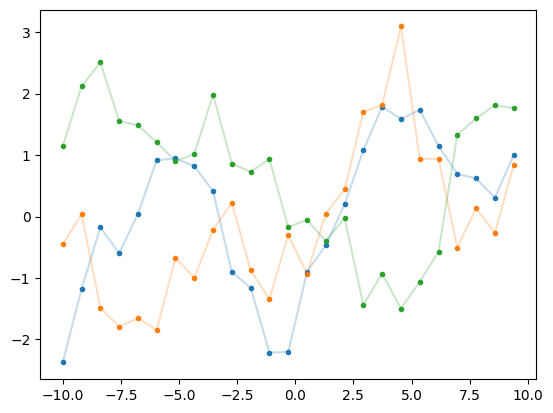

In [16]:
plot_some_sequences()

We provide a function for finding the best program out of a list that matches a given data sequence:

In [17]:
def evaluate_all_programs(dsl, programs):
    filtered_programs, evaluations = [], []
    for prog in programs:
        try:
            actual_fn = dsl.compute(dsl.initialize(prog))
        except:
            continue
        ys = []
        for inp in xs:
            y = run_safely(actual_fn, inp)
            if y is None or not (-2 <= y <= 2):
                break
            ys.append(y)
        else:
            filtered_programs.append(prog)
            evaluations.append(ys)
    return filtered_programs, np.array(evaluations)

def best_fits(dsl, family, dist):
    programs = [prog for prog, _ in itertools.islice(family.enumerate(dist), 5000)]
    programs = sorted(programs, key=lambda x: len(ns.render_s_expression(x)))
    filtered_programs, ys = evaluate_all_programs(dsl, programs)
    errors = ((ys[None] - values[:,None]) ** 2).sum(-1)
    program_idxs = errors.argmin(1)
    print("Mean error: ", errors.min(1).mean())
    return [filtered_programs[i] for i in program_idxs]

def plot_programs_against_data(dsl, best_programs):
    plot_some_sequences()
    best_programs = best_programs[:plot_count]
    _, evals = evaluate_all_programs(dsl, best_programs)
    for prog, ev in zip(best_programs, evals):
        plt.plot(xs, ev, label=ns.render_s_expression(prog).replace("$", r"\$"))
    plt.legend()

Now we find the best programs among the first 50k enumerated programs

In [18]:
best_programs = best_fits(dsl, dist_family, uniform)

<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: divide by zero encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: invalid value encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:5: RuntimeWarning: invalid value encountered in scalar multiply
  dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y) # multiplication, two arguments
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: overflow encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function


Mean error:  22.90542878322628


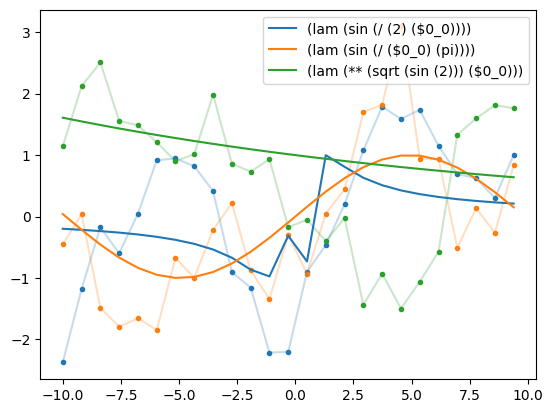

In [19]:
plot_programs_against_data(dsl, best_programs)

We can see that the programs that were found roughly follow the trends of the samples. However, these values could still be improved, as we have a mean error of 22,905.

### Exercise 3A: Fitting a DSL

Now we will refine our search. First, we fit a distribution to the `best_programs`. We will bound the minimum likelihood of each symbol at 0.01, but feel free to try and change it. If you do so, comment on the result:

After printing the mean errors for minimum likelihoods from 0.01 to 0.20, the best score was obtained for a value of 0.02 (16.799).

Check with the functions defined above how the mean error changes now that we have fitted the distribution to the best programs, and plot the new programs like above:

In [20]:
fitted_dist = dist_family.fit_distribution(best_programs).bound_minimum_likelihood(0.01)

In [21]:
# Check that the fitted distribution actually makes the error smaller
best_programs_fitted = best_fits(dsl, dist_family, fitted_dist)

<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: divide by zero encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: invalid value encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function
<ipython-input-5-23af2ddcd0da>:23: RuntimeWarning: overflow encountered in power
  dslf.concrete("**", "(f, f) -> f", lambda x, y: np.power(x, y)) # Power function


Mean error:  17.10518139585418


In [23]:
import warnings
warnings.filterwarnings('ignore')

N = 20

# We print the mean error for each value of min. likelihood binding
for i in range(N):
  print(f'For {i/100}: ', end='')
  fitted_dist = dist_family.fit_distribution(best_programs).bound_minimum_likelihood(i/100)
  best_programs_fitted = best_fits(dsl, dist_family, fitted_dist)

For 0.0: Mean error:  18.104710912287455
For 0.01: Mean error:  17.10518139585418
For 0.02: Mean error:  16.7993661920123
For 0.03: Mean error:  16.963123559864133
For 0.04: Mean error:  17.162963896813977
For 0.05: Mean error:  17.307724312664387
For 0.06: Mean error:  17.429693429790756
For 0.07: Mean error:  17.40591958148252
For 0.08: Mean error:  17.382383828076165
For 0.09: Mean error:  17.501863921684517
For 0.1: Mean error:  17.65256572393303
For 0.11: Mean error:  18.011374132534424
For 0.12: Mean error:  17.91664484721957
For 0.13: Mean error:  18.142335008822013
For 0.14: Mean error:  18.20034684957863
For 0.15: Mean error:  18.22763011013197
For 0.16: Mean error:  18.036109575061694
For 0.17: Mean error:  17.975885887250385
For 0.18: Mean error:  18.201268350979703
For 0.19: Mean error:  18.571564378734926


Mean error:  16.7993661920123


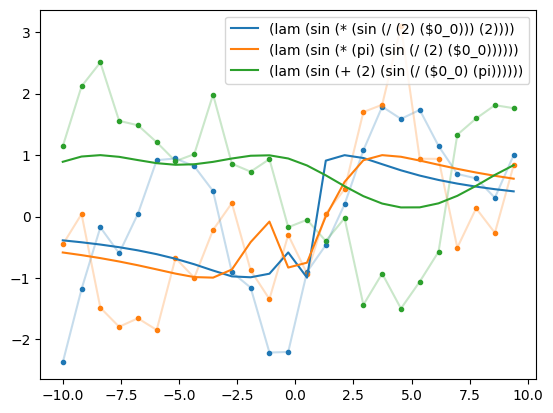

In [29]:
# Replotting the results with the optimal minimum likelihood
fitted_dist = dist_family.fit_distribution(best_programs).bound_minimum_likelihood(0.02)
best_programs_fitted = best_fits(dsl, dist_family, fitted_dist)
plot_programs_against_data(dsl, best_programs_fitted)

After bounding the minimum likelihoods of our programs to 0.02, we can see a clear improvement on the mean error which reduces from 22,905 to 16,799 (approximatively a 25% improvement).

### Exercise 3B: Abstractions

Let's now introduce abstractions to our DSL. This means going through the best programs we have already found, find common subsequences, and abstract them into new symbols of our DSL.

We will introduce 5 new abstractions. Once done, obtain a new distribution family from the new DSL as we have done before, and then fit a distribution from that family to the rewritten programs. Bound also that distribution to a minimum likelihood of 0.01:

In [34]:
# We recreate our environment with abstraction
abstraction_dsl, rewritten = ns.compression.multi_step_compression(dsl, best_programs_fitted, 5)
abstraction_family = ns.BigramProgramDistributionFamily(abstraction_dsl)
abstraction_dist = abstraction_family.fit_distribution(best_programs).bound_minimum_likelihood(0.01)

Visualize your dsl and the new abstractions that have been introduced.

In [35]:
# visualize dsl
print(abstraction_dsl.render())

              0 :: () -> f
              1 :: () -> f
           sqrt :: f -> f
              * :: (f, f) -> f
              < :: (f, f) -> c
              2 :: () -> f
             pi :: () -> f
              + :: (f, f) -> f
              / :: (f, f) -> f
             ** :: (f, f) -> f
            sin :: f -> f
        if_else :: (c, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>
           __10 :: (f, f) -> f = (lam-abstr (#0 #1) (sin (/ #1 #0)))
           __20 :: f -> f = (lam-abstr (#0) (sin (+ #0 (pi))))
           __30 :: f -> f = (lam-abstr (#0) (** (0) (** (0) #0)))
           __40 :: (f, f) -> f = (lam-abstr (#0 #1) (sin (* #1 #0)))
           __50 :: f -> f -> f = (lam-abstr (#0) (lam (__10 (2) (+ ($0_0) #0))))


Can you understand which functions do the abstractions introduced refer to? (Note: #number in the definition of the abstraction refer to a input parameter.)

Your answer:

1. $f_1(x, y) = sin(\frac{y}{x})$

2. $f_2(x) = sin(x+ \pi)$

3. $f_3(x) = 0^{0^x}$

4. $f_4 = f(x, y) = sin(y*x) $

5. $f_5(x) = f(x') = sin(\frac{x'+x}{2})$

Most of these abstraction combine the sin function with mathematical operations. The DSL was compressed into smaller forms in order to spot and implement patterns. These patterns can be really hard for the system to reconstruct every time and using their abstraction can really make the computation lighter.

Now check that the abstractions have had a positive effect to the mean error.

In [36]:
best_programs_abstractions = best_fits(abstraction_dsl, abstraction_family, abstraction_dist)

Mean error:  16.5165478372867


Adding abstraction clearly had a positive effect on the mean error. The reduction is small but still significant.

Finally, let's plot some programs against the data and see how they fit:

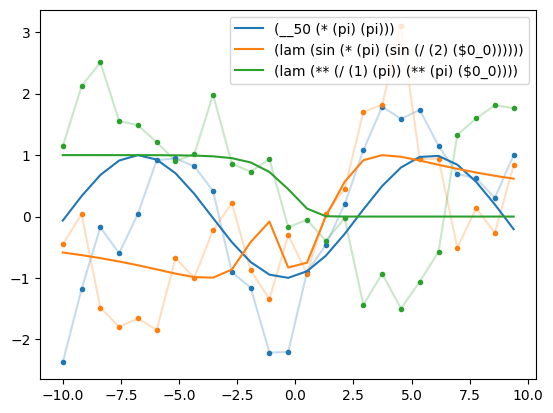

In [37]:
plot_programs_against_data(abstraction_dsl, best_programs_abstractions)

The graph clearly shows that the curves of our programs now follow the values more closely. It is still not perfect but the point is that adding a bounded minimum likelihood as well as abtraction made us reduce the mean error and made our curves come closer to their expected values.

It was also able to simplify the expression of our first function to a smaller form.

To conclude, we can once again underline the efficiency of combining program synthesis with abstraction. On our small context, it was able to help us find more accurate results. Moreover, if we picture it on a higher scale (for example on the Dreamcoder project), it clearly shows that introducing abstraction to a DSL can really improve its performance on creating accurate programs.

Hopefully, by now you understand how abstractions are important and how they make it easier to find better and better programs the more we intertwine search and introduction of abstractions.

We search for programs, introduce abstractions, find better programs with the abstractions, then introduce more asbtractions... and so on! Dreamcoder, which you have seen in the lectures, is a great example of this mechanism, and the results they obtain in their paper (https://arxiv.org/abs/2006.08381) is a testament of how powerful methods that combine library learning with neural networks can be.